# 1 Sistema de Seleção Unificada (SISU)
## 2 Efeitos Sobre a Migração e Evasão Estudantil na Universidade Federal da Paraíba
### Introdução
Este trabalho busca entender os efeitos do Sistema de Seleção Unificada, o Sisu,
no perfil do entrante e a sua relação com a evasão estudantil na Universidade Federal da
Paraíba. Esse sistema de seleção pode afetar as escolhas individuais de tal modo que o
concorrente passe a escolher um curso no qual ele tenha maior probabilidade de
aprovação ao invés de sua escolha ótima e isto pode ter efeitos nos indicadores de evasão.
Para tal análise, essa pesquisa tem como base um banco de dados interno obtido junto a
Superintendência de Tecnologia da Informação (STI) da UFPB para o período de 2010 a
2015.


### 2.1 Projeto de Ciências de Dados - machine learning 
### 2.2 Análise Exploratória e Data Wrangling Para efeitos do Sisu na migração e Evasão estudantil na UFPB


In [1]:
#imports
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Parâmetros de configuração dos gráficos
from matplotlib import rcParams
rcParams['figure.figsize'] = 12, 4
rcParams['lines.linewidth'] = 3
rcParams['xtick.labelsize'] = 'x-large'
rcParams['ytick.labelsize'] = 'x-large'

### 2.3 Carregando dados

In [3]:
# Carregando os dados que estão em formato .xlsx
df = pd.read_excel('STI_UFPB.xlsx')

In [4]:
# Verificando o tipo de objeto criado
type(df)

pandas.core.frame.DataFrame

In [5]:
# Atributo shape
df.shape

(68947, 24)

In [6]:
# Verificando o total de registro do df
df.size

1654728

In [7]:
# Método head?()
df.head(5)

,campus,codigo_inep,curso_nome,turno,ano_ingresso,periodo_ingresso,forma_ingresso,status,id_discente,ano_referencia,...,etnia,sexo,data_nascimento,uf_naturalidade,mun_residencia,uf_residencia,dt_conclusao,dt_expedicao,estado_civil,renda_familiar
0,João Pessoa,NaN,CIENCIAS,Matutino e Vespertino,1979,1,GRADUADO,CONCLUÍDO,47289,2016,...,Não Informado,F,1900-01-01 00:00:00,Paraíba,_Outros,#Não Informado,NaT,NaT,Divorciado(a),NaN
1,João Pessoa,13398.0,DIREITO,Noturno,1980,1,TRANSFERENCIA (PSTV),CANCELADO,92456,2010,...,Não Informado,M,1955-11-19 00:00:00,Paraíba,João Pessoa,Paraíba,NaT,NaT,Casado(a),40000.0
2,João Pessoa,13423.0,EDUCAÇÃO FÍSICA - LICENCIATURA,Matutino e Vespertino,1982,2,VESTIBULAR,CANCELADO,54848,2014,...,Pardo,M,1958-08-12 00:00:00,Paraíba,João Pessoa,Paraíba,NaT,NaT,Divorciado(a),NaN
3,João Pessoa,13400.0,FÍSICA,Matutino e Vespertino,1982,1,VESTIBULAR,CONCLUÍDO,54058,2016,...,Não Informado,M,1952-11-12 00:00:00,Paraíba,João Pessoa,Paraíba,2016-07-04,2017-07-04,Casado(a),NaN
4,João Pessoa,13400.0,FÍSICA,Matutino e Vespertino,1982,1,VESTIBULAR,CONCLUÍDO,54058,2016,...,Não Informado,M,1952-11-12 00:00:00,Paraíba,João Pessoa,Paraíba,2016-07-04,2017-07-04,Casado(a),NaN


#### Removendo variáveis com valores NaN

In [8]:
df = df.drop(['dt_conclusao', 'dt_expedicao', 'renda_familiar'], axis=1)

In [9]:
df.shape

(68947, 21)

In [10]:
df = df.dropna()

In [11]:
df.shape

(68940, 21)

### 2.4 EDA - Parte 1
### 2.4.1 Separação das Variáveis Categóricas e Numéricas

Antes de dar inicio a separação dos dados por variáveis categóricas e númericas, irei fazer um subset dos dados para os alunos que ingressaram na UFPB de 2010 até 2015.

In [12]:
df1 = df.loc[(df.ano_ingresso > 2009) & (df.ano_ingresso < 2016)]

In [13]:
df1.head(5)

,campus,codigo_inep,curso_nome,turno,ano_ingresso,periodo_ingresso,forma_ingresso,status,id_discente,ano_referencia,...,forma_evasão,cra,cota,etnia,sexo,data_nascimento,uf_naturalidade,mun_residencia,uf_residencia,estado_civil
19029,João Pessoa,13413.0,PSICOLOGIA,Matutino e Vespertino,2010,2,VESTIBULAR,CONCLUÍDO,131557,2013,...,CONCLUÍDO,0.0,Ampla Concorrência,Branco,M,1993-01-31 00:00:00,Paraíba,Patos,Paraíba,Solteiro(a)
19030,Litoral Norte (Mamanguape e Rio Tinto),98976.0,CIÊNCIAS CONTÁBEIS,Noturno,2010,1,TRANSFERENCIA (PSTV),CANCELADO,134499,2012,...,CANCELAMENTO DE MATRÍCULA E VÍNCULO PELO ALUNO,82800.0,Ampla Concorrência,Branco,M,1991-06-17 00:00:00,Pernambuco,Itambé,Pernambuco,Solteiro(a)
19031,João Pessoa,13404.0,QUÍMICA,Noturno,2010,1,VESTIBULAR,CANCELADO,132561,2011,...,CANCELAMENTO DE MATRÍCULA E VÍNCULO PELO ALUNO,47500.0,Ampla Concorrência,Pardo,M,1984-09-04 00:00:00,Paraíba,João Pessoa,Paraíba,Solteiro(a)
19032,João Pessoa,13427.0,ARQUITETURA E URBANISMO,Matutino e Vespertino,2010,2,VESTIBULAR,CANCELADO,148073,2016,...,ABANDONO,75800.0,Ampla Concorrência,Branco,F,1991-05-13 00:00:00,Paraíba,João Pessoa,Paraíba,Solteiro(a)
19033,João Pessoa,13397.0,CIÊNCIAS CONTÁBEIS,Matutino e Vespertino,2010,2,TRANSFERENCIA (PSTV),CONCLUÍDO,138208,2016,...,CONCLUÍDO,69200.0,Ampla Concorrência,Branco,F,1991-06-10 00:00:00,Pernambuco,João Pessoa,Paraíba,Solteiro(a)


Aqui irei criar dois vetores que serão importantes para seguir com o objetivo desse projeto

Removendo erros da variável **sexo**

In [14]:
df1 = df1[df1['sexo'] != 'N']

In [15]:
df1['sexo'].value_counts()

F    23581
M    22580
Name: sexo, dtype: int64

Removendo erros do vetor **ano_referencia**

In [16]:
df1 = df1[(df1['ano_referencia'] != 2071) & (df1['ano_referencia'] != 2091)]

In [17]:
df1['ano_referencia'].value_counts()

2016    8211
2015    7456
2017    6518
2014    6311
2013    4869
2018    4752
2019    3687
2012    2521
2011    1523
2020     167
2010     144
2022       1
Name: ano_referencia, dtype: int64

Ao fazer a contagem dos anos presentes em **ano_referencia** foi verificado uma única contagem para o ano de 2022.

A seguir irei usar a biblioteca *Numpy* para criação de dois novos vetores com as informações das variáveis **forma_ingresso** e **uf_residencia**.

   1. Irei criar uma variável *dummy* chamada **ingresso_sisu** essa variável recebera o valor *0* para os alunos que ingressaram na UFPB por meios distintos ao Sisu e valor *1* para os estudantes que ingressaram na instituição por meio do Sisu.
   
   
   2. A partir da variável **uf_residencia** criarei uma variável *dummy* chamada **aluno_migrante** onde os estudantes que possuem residência no estado paraibano receberam o valor *0* e os estudantes que tem sua residência em outros estados receberam o valor *1*.

In [18]:
df1['ingresso_sisu'] = np.where(df1['forma_ingresso'].isin(['ENEM/SiSU']), 1, 0).astype('object')
df1['aluno_migrante'] = np.where(df1['uf_residencia'].isin(['Paraíba']),0, 1).astype('object')

In [19]:
# Método info()
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46160 entries, 19029 to 65200
Data columns (total 23 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   campus              46160 non-null  object 
 1   codigo_inep         46160 non-null  float64
 2   curso_nome          46160 non-null  object 
 3   turno               46160 non-null  object 
 4   ano_ingresso        46160 non-null  int64  
 5   periodo_ingresso    46160 non-null  int64  
 6   forma_ingresso      46160 non-null  object 
 7   status              46160 non-null  object 
 8   id_discente         46160 non-null  int64  
 9   ano_referencia      46160 non-null  int64  
 10  periodo_referencia  46160 non-null  float64
 11  forma_evasão        46160 non-null  object 
 12  cra                 46160 non-null  float64
 13  cota                46160 non-null  object 
 14  etnia               46160 non-null  object 
 15  sexo                46160 non-null  object 
 16  

In [20]:
df1.head(5)

,campus,codigo_inep,curso_nome,turno,ano_ingresso,periodo_ingresso,forma_ingresso,status,id_discente,ano_referencia,...,cota,etnia,sexo,data_nascimento,uf_naturalidade,mun_residencia,uf_residencia,estado_civil,ingresso_sisu,aluno_migrante
19029,João Pessoa,13413.0,PSICOLOGIA,Matutino e Vespertino,2010,2,VESTIBULAR,CONCLUÍDO,131557,2013,...,Ampla Concorrência,Branco,M,1993-01-31 00:00:00,Paraíba,Patos,Paraíba,Solteiro(a),0,0
19030,Litoral Norte (Mamanguape e Rio Tinto),98976.0,CIÊNCIAS CONTÁBEIS,Noturno,2010,1,TRANSFERENCIA (PSTV),CANCELADO,134499,2012,...,Ampla Concorrência,Branco,M,1991-06-17 00:00:00,Pernambuco,Itambé,Pernambuco,Solteiro(a),0,1
19031,João Pessoa,13404.0,QUÍMICA,Noturno,2010,1,VESTIBULAR,CANCELADO,132561,2011,...,Ampla Concorrência,Pardo,M,1984-09-04 00:00:00,Paraíba,João Pessoa,Paraíba,Solteiro(a),0,0
19032,João Pessoa,13427.0,ARQUITETURA E URBANISMO,Matutino e Vespertino,2010,2,VESTIBULAR,CANCELADO,148073,2016,...,Ampla Concorrência,Branco,F,1991-05-13 00:00:00,Paraíba,João Pessoa,Paraíba,Solteiro(a),0,0
19033,João Pessoa,13397.0,CIÊNCIAS CONTÁBEIS,Matutino e Vespertino,2010,2,TRANSFERENCIA (PSTV),CONCLUÍDO,138208,2016,...,Ampla Concorrência,Branco,F,1991-06-10 00:00:00,Pernambuco,João Pessoa,Paraíba,Solteiro(a),0,0


Foram detectados nas variáveis **dt_conlcusão**, **dt_expedição** e **renda_familiar** valores ausentes. Sendo a última dessas com maior número de informação faltantes.

Foi observado acima que alguns **Dtype** estão incorretos são eles: **periodo_ingresso**, **id_discente**, **Periodo_referencia**

In [21]:
#Loop Para corrigir Dtype
colunas= ['periodo_ingresso', 'id_discente', 'periodo_referencia', 'codigo_inep']

for coluna in colunas:
    df1[coluna] = df1[coluna].astype('object')

In [22]:
#lista de variáveis numéricas
nums = df1.select_dtypes(include=['int', 'float'])
nums = nums.columns.tolist()
print(nums)

['ano_ingresso', 'ano_referencia', 'cra']


In [23]:
type(nums)

list

In [24]:
# Selecionando todas a variáveis categóricas
cats = df1.select_dtypes(include=['object'])
cats = cats.columns.tolist()
print(cats)

['campus', 'codigo_inep', 'curso_nome', 'turno', 'periodo_ingresso', 'forma_ingresso', 'status', 'id_discente', 'periodo_referencia', 'forma_evasão', 'cota', 'etnia', 'sexo', 'data_nascimento', 'uf_naturalidade', 'mun_residencia', 'uf_residencia', 'estado_civil', 'ingresso_sisu', 'aluno_migrante']


In [25]:
df1['cra'] = df1['cra']/1000

### 2.4.2 Explorando as Variáveis Numéricas

In [26]:
# Resumo das variáveis numéricas
df1[nums].describe()

,ano_ingresso,ano_referencia,cra
count,46160.000000,46160.000000,46160.000000
mean,2012.348960,2015.447769,45.801744
std,1.634759,2.119995,35.046405
min,2010.000000,2010.000000,0.000000
25%,2011.000000,2014.000000,0.000040
50%,2012.000000,2016.000000,52.900000
75%,2014.000000,2017.000000,79.600000
max,2015.000000,2022.000000,100.000000


In [27]:
df1['forma_ingresso'].value_counts()

VESTIBULAR                             24398
ENEM/SiSU                              17330
GRADUADO                                1702
TRANSFERENCIA (PSTV)                    1051
REOPCAO DE CURSO                         935
REING. PRG RES CONSEPE no. 082 2011      191
TRANSFERENCIA EX-OFICIO                  131
ENEM/SISU-DECISÃO JUDICIAL                70
PSS - POR LIMINAR                         43
DECISAO CONSEPE-REC. PROC. SELETIVO       42
PEC - MSC                                 37
PEC-G                                     33
REOPCAO DE TURNO                          30
DECISAO JUDICIAL CAD PSS                  26
TRANSFERENCIA POR FORCA LIMINAR           24
PROGRAMA DE MOBILIDADE ESTUDANTIL         20
REINGRESSO POR DECISAO DO CONSEPE         19
MUDANCA DE CAMPUS/CURSO AUT CONSEPE       13
PROGRAMA PIANI                            13
REINGRESSO POR DECISAO JUDICIAL           11
VESTIBULAR-PROESP/OUTROS ORG.PUB.         11
CAD/AUT/PRG/RES 05/2012                    8
REOPCAO PE

Observações:

   * As variáveis **ano_ingresso**, **ano_referencia** parecem ter uma distribuição simétrica. Elas mostram estar próximas de distribuição normal, pois os valores da média e mediana são parecidos.
   
   * Já a variável **cra** tem a média menor que a mediana o que nos diz que a distribuição dessa variável pode ser assimétrica positiva, ou seja, a cauda da curva de distribuição declina para direita.   

**Vejamos alguns histogramas para avaliar a distribuição das variáveis**

<AxesSubplot:>

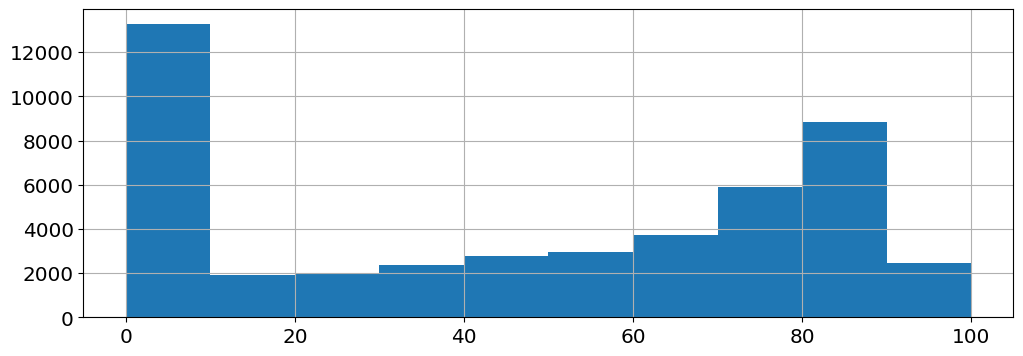

In [28]:
df1['cra'].hist()

Como tínhamos visto anteriormente a variável **cra** não segue uma distribuição normal. Vimos ainda que, esse vetor indicava ter uma distribuição assimétrica positiva na qual sua cauda se alongava para a direita.
Ao observar o gráfico é visto várias contagens próximo do valor *0* e esse número reduz de forma brusca logo em seguida.

<AxesSubplot:>

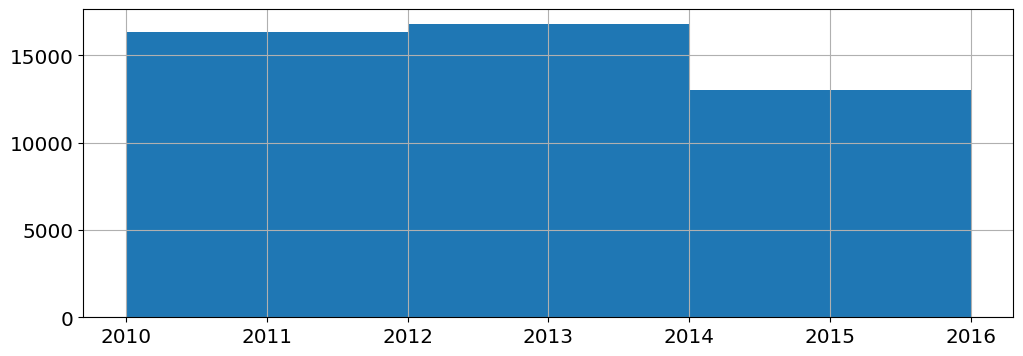

In [29]:
df1['ano_ingresso'].hist(bins=[2010,2012,2014,2016])

Esse histograma apresenta uma distribuição uniforme, isso nos diz que cada frequência apresenta aproximadamente o mesmo número de observações.

<AxesSubplot:>

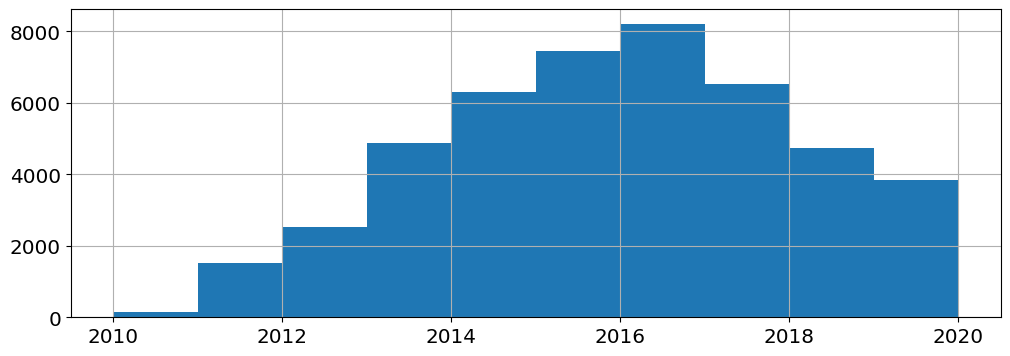

In [30]:
df1.loc[df1['ano_referencia'] < 2021, 'ano_referencia'].hist()

A variável **ano_referencia** tem uma distribuição próxima de uma distribuição normal.

### **Análise Univariada - Box Plots**

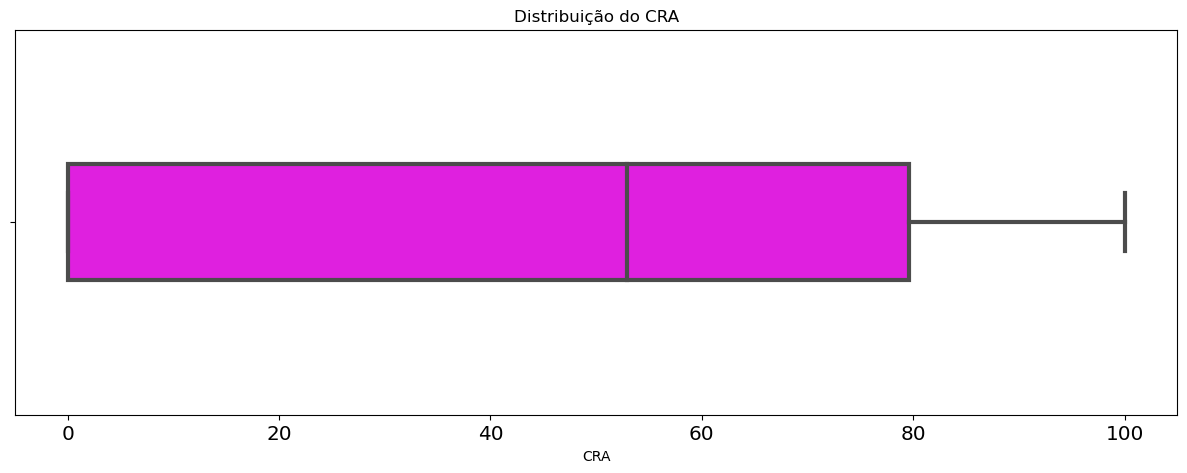

In [31]:
# Criação do boxplot
plt.figure(figsize=(15, 5))  # define o tamanho da figura
sns.boxplot(x=df1['cra'], color='magenta', width=0.3)  # ajusta a largura da caixa

# Configuração dos eixos e do título
plt.xlabel("CRA")
plt.title("Distribuição do CRA")

# Mostrar o gráfico
plt.show()

**cra**

1. A linha da mediana do vetor **cra** está próximo de *53*. É possível observa maior concentração dos dados no primeiro quartil.
2. Os valores mínimo e máximo foram respectivamente o ano de 0 e 100.
3. Não foram identificados valores outliers para a variável **cra**.

### 2.4.3 Explorando as Variáveis Categóricas

In [32]:
df1[cats].describe()

,campus,codigo_inep,curso_nome,turno,periodo_ingresso,forma_ingresso,status,id_discente,periodo_referencia,forma_evasão,cota,etnia,sexo,data_nascimento,uf_naturalidade,mun_residencia,uf_residencia,estado_civil,ingresso_sisu,aluno_migrante
count,46160,46160.0,46160,46160,46160,46160,46160,46160,46160.0,46160,46160,46160,46160,46160,46160,46160,46160,46160,46160,46160
unique,4,114.0,91,4,2,36,2,44732,5.0,18,17,6,2,9015,29,500,28,9,2,2
top,João Pessoa,13418.0,PEDAGOGIA,Matutino e Vespertino,1,VESTIBULAR,CANCELADO,133500,1.0,CONCLUÍDO,Ampla Concorrência,Branco,F,1992-05-20 00:00:00,Paraíba,João Pessoa,Paraíba,Solteiro(a),0,0
freq,38739,1791.0,2476,27378,27570,24398,27542,6,26736.0,18097,36031,17885,23580,29,38915,29470,43022,39767,28830,43022


Observações:
   * A variável **forma_ingresso** tem como classe dominante o *VESTIBULAR*;
   * Para a variável **status** a classe dominante foi *CANCELADO*;
   * Já a variável **forma_evasão** a classe dominante é *CONCLUÍDO*;
   * A variável **cota** tem *AMPLA COMCORRÊNCIA* como classe dominante;
   * Para a variável **etnia** a classe *BRANCO* é dominante;
   * **Sexo** tem como classe dominante *F* que representa o sexo feminino;
   * Para **ingresso_sisu** a classe dominante é *0* que representa os estudantes que ingressaram pelo SISU;
   * Já **aluno_migrante** a classe que domina também é *0* representando os estudantes com residência no estado da Paraíba.

In [33]:
# Listando o total por categoria de cada variável categórica
var = ['status', 'etnia', 'sexo', 'ingresso_sisu', 'aluno_migrante']
for col in var:
    print(f'''Total de Registros Por Categoria da Variável {col}:''')
    print(df1[col].value_counts())
    print()

Total de Registros Por Categoria da Variável status:
CANCELADO    27542
CONCLUÍDO    18618
Name: status, dtype: int64

Total de Registros Por Categoria da Variável etnia:
Branco           17885
Pardo            16426
Não Informado     7481
Negro             3070
Amarelo            958
Indígeno           340
Name: etnia, dtype: int64

Total de Registros Por Categoria da Variável sexo:
F    23580
M    22580
Name: sexo, dtype: int64

Total de Registros Por Categoria da Variável ingresso_sisu:
0    28830
1    17330
Name: ingresso_sisu, dtype: int64

Total de Registros Por Categoria da Variável aluno_migrante:
0    43022
1     3138
Name: aluno_migrante, dtype: int64



**Logo abaixo veremos características e informações dos alunos considerados Não Migrantes**
    
   * Considerei como aluno não migrante os estudantes que tem residência na Paraíba.

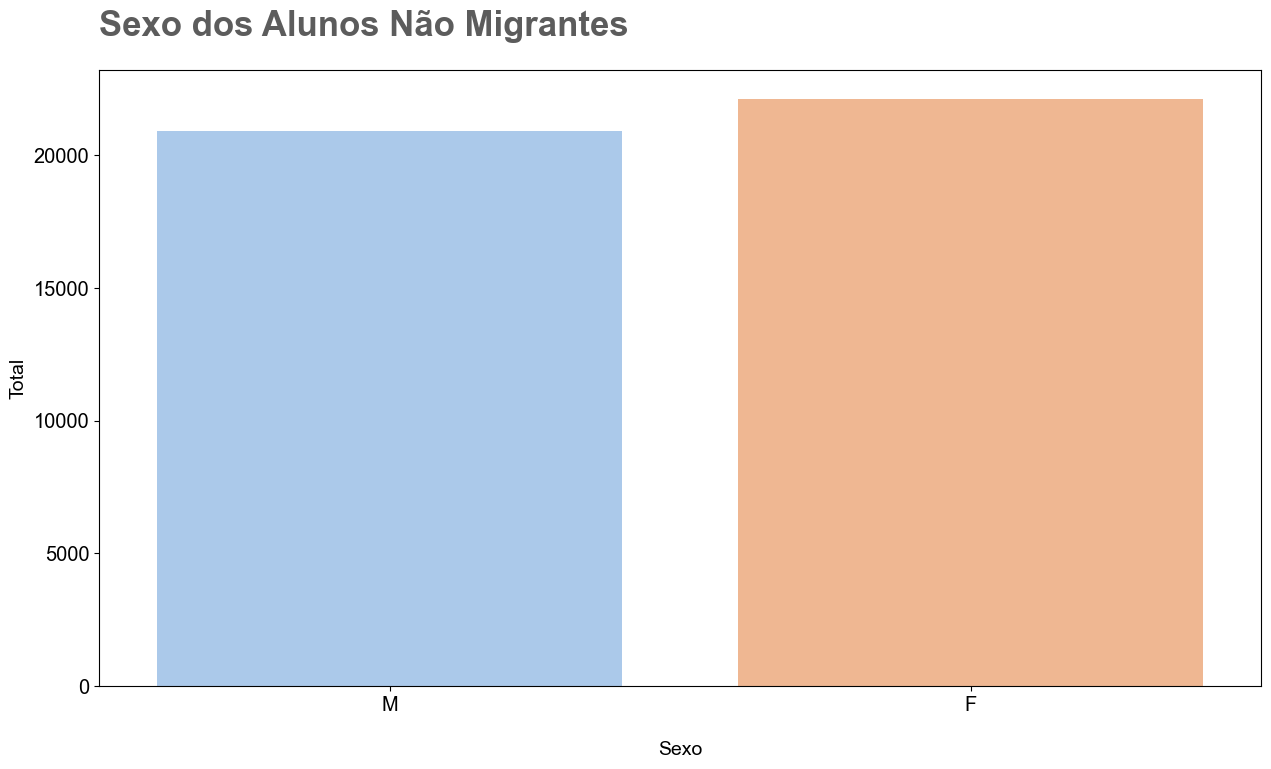

In [34]:
# Gráfico 1 - Análise em Valores Absolutos

# Tamanho da figura
plt.figure(figsize = (15,8))

# Selecionando a paleta de cores
palette = sns.color_palette("pastel")

# Chart
chart = sns.countplot(data = df1.loc[(df1['aluno_migrante'] == 0)], x = 'sexo', palette = palette)

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nSexo", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Adicionado Título
chart.text(x = -0.5,
           y = 24500,
           s = "Sexo dos Alunos Não Migrantes",
           fontsize = 25,
           weight = 'bold',
           alpha = .75);

* Observando a distribuição dos alunos considerado como não migrantes, foi visto que a maioria é do sexo **feminino**. Contudo ao observar o gráfico não parece existir grande diferença entre os sexos **masculino** e **feminino** desses alunos.

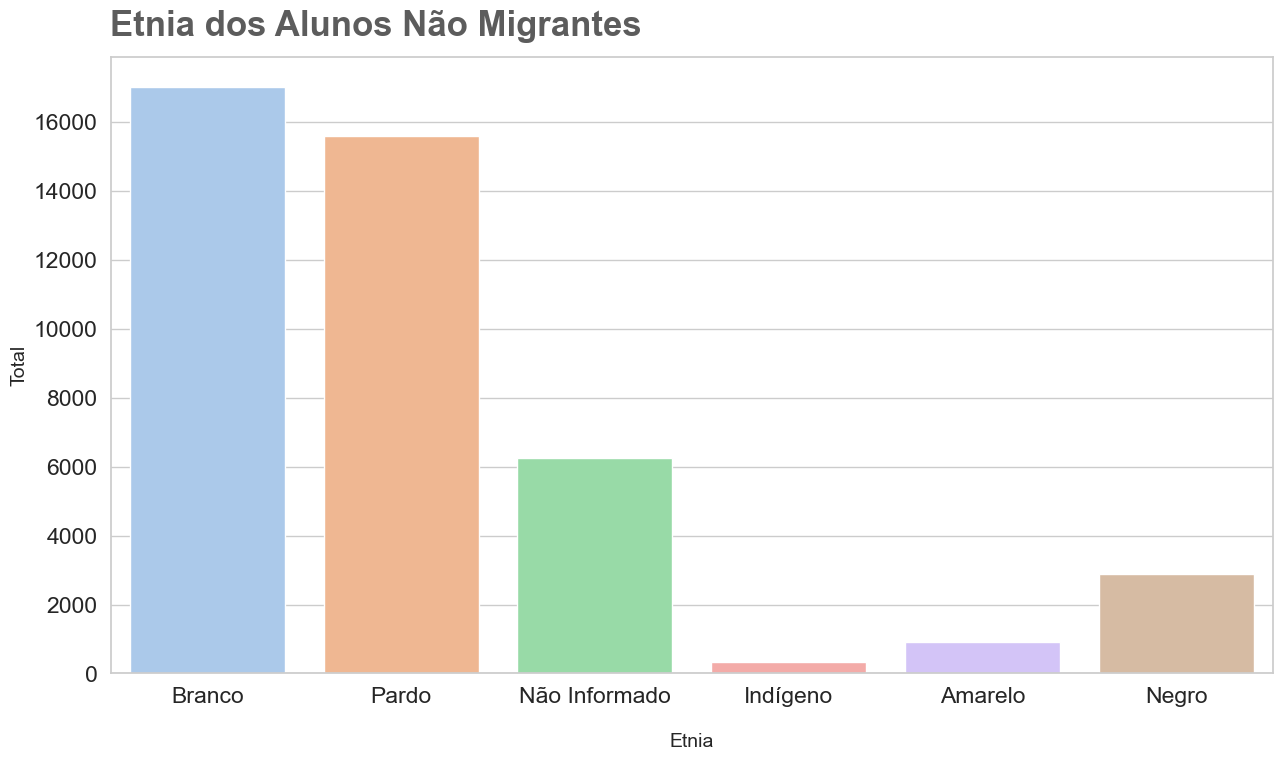

In [35]:
# Gráfico 2 - Análise em Valores Absolutos

# Tamanho da figura
plt.figure(figsize = (15,8))

# Selecionando a paleta de cores
palette = sns.color_palette("pastel")

# Chart
chart = sns.countplot(data = df1.loc[(df1['aluno_migrante'] == 0)], x = 'etnia',  palette=palette)

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nEtnia", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Adicionado Título
chart.text(x = -0.5,
           y = 18500,
           s = "Etnia dos Alunos Não Migrantes",
           fontsize = 25,
           weight = 'bold',
           alpha = .75);

* Ao analisar a frequência dos alunos não migrantes de acordo com a etnia é visto que:

    1. em sua maioria os alunos não migrantes são **Brancos** e **Pardos**; 

    2. Ainda é possível ver que os grupos com menor representatividade são os **Indígenas** e **Amarelos**;

    3. É importante ressaltar ainda que de acordo com os dados presentes boa parte desses estudantes não tem sua etnia informada.

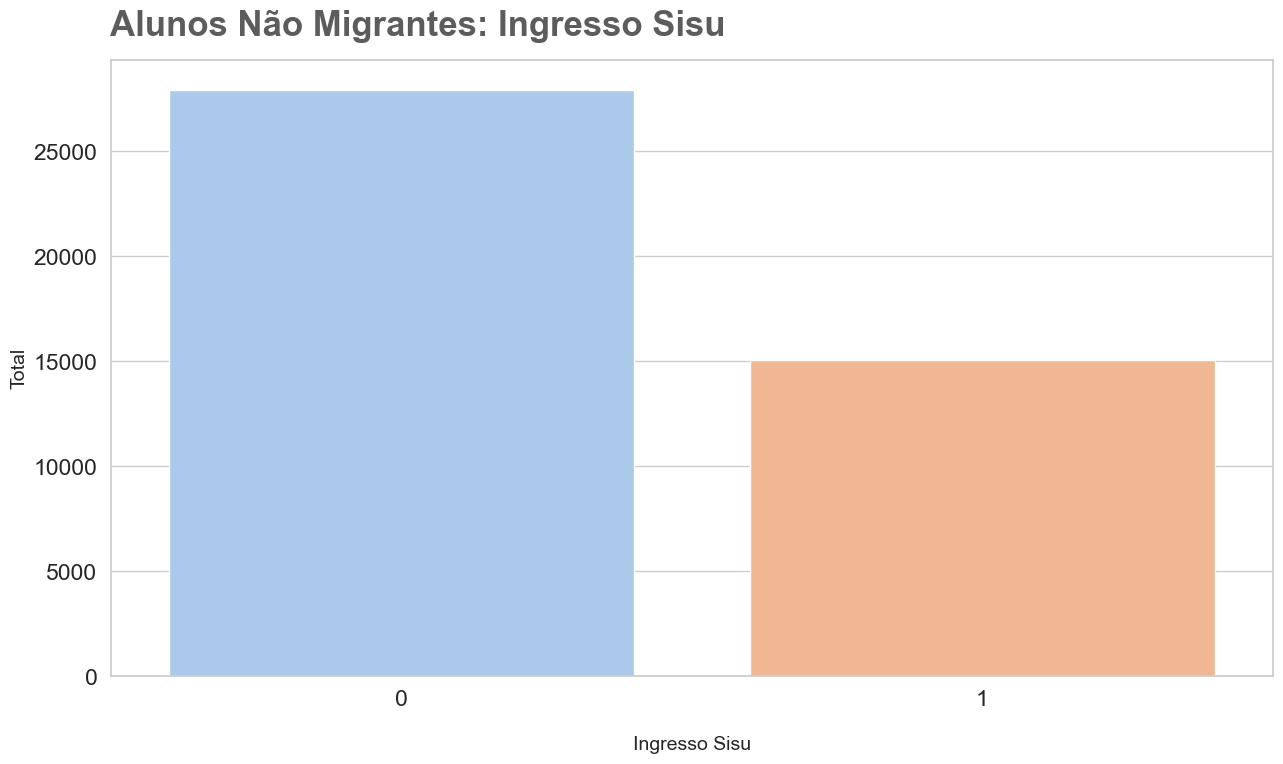

In [36]:
# Gráfico 3 - Análise em Valores Absolutos

# Tamanho da figura
plt.figure(figsize = (15,8))

# Selecionando a paleta de cores
palette = sns.color_palette("pastel")

# Chart
chart = sns.countplot(data = df1.loc[(df1['aluno_migrante'] == 0)], x = 'ingresso_sisu', palette = palette)

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nIngresso Sisu", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Adicionado Título
chart.text(x = -0.5,
           y = 30500,
           s = "Alunos Não Migrantes: Ingresso Sisu",
           fontsize = 25,
           weight = 'bold',
           alpha = .75);

É possível ver no plot acima que a maior parte dos estudantes residentes na PB, ingressaram na UFPB por sistemas de seleção distintos do Sisu.

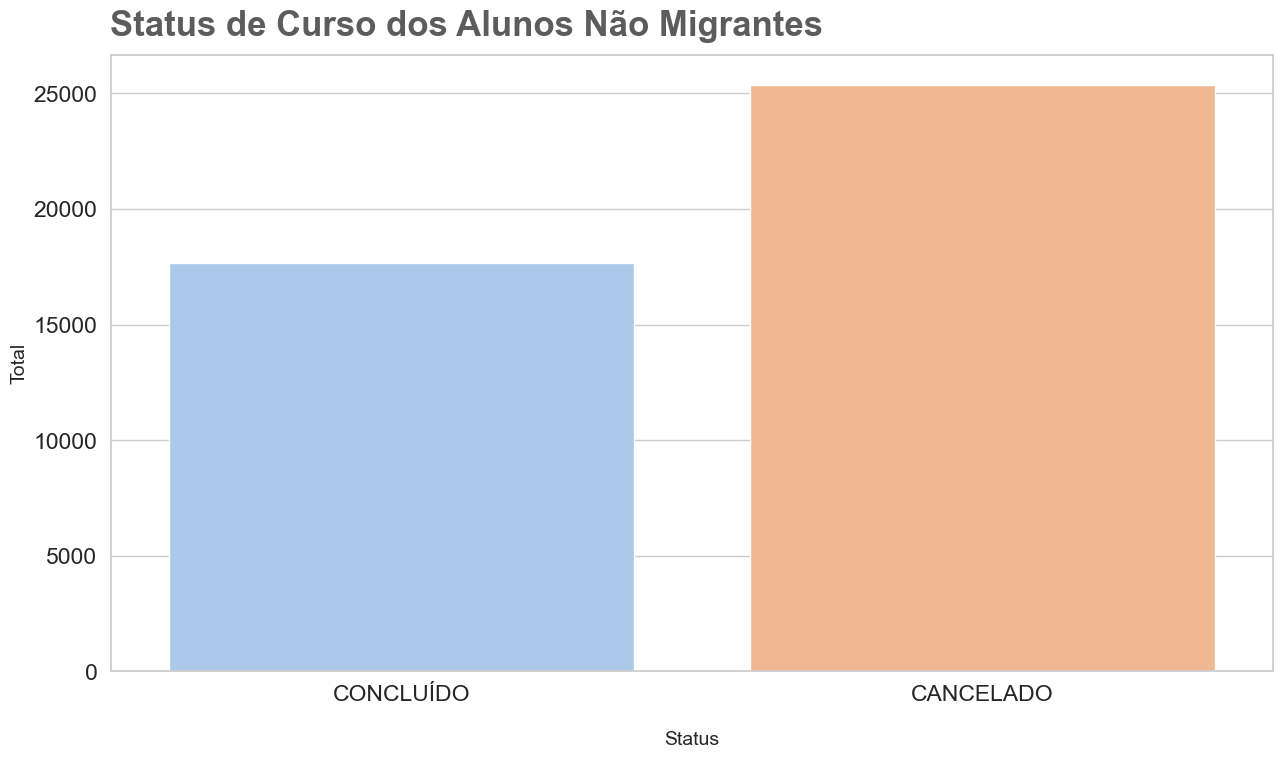

In [37]:
# Gráfico 4 - Análise em Valores Absolutos

# Tamanho da figura
plt.figure(figsize = (15,8))

# Selecionando a paleta de cores
palette = sns.color_palette("pastel")

# Chart
chart = sns.countplot(data = df1.loc[(df1['aluno_migrante'] == 0)], x = 'status', palette = palette)

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nStatus", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Adicionado Título
chart.text(x = -0.5,
           y = 27500,
           s = "Status de Curso dos Alunos Não Migrantes",
           fontsize = 25,
           weight = 'bold',
           alpha = .75);

Nesse gráfico é possível ver que a contagem de frequência para os alunos não migrantes que tiveram seus cursos **cancelados** é maior que os **concluídos**.

### **Agora veremos informações e características dos alunos migrantes** 

   * Considerei como aluno migrante os estudantes que tem residência em estados diferente do estado da Paraíba.

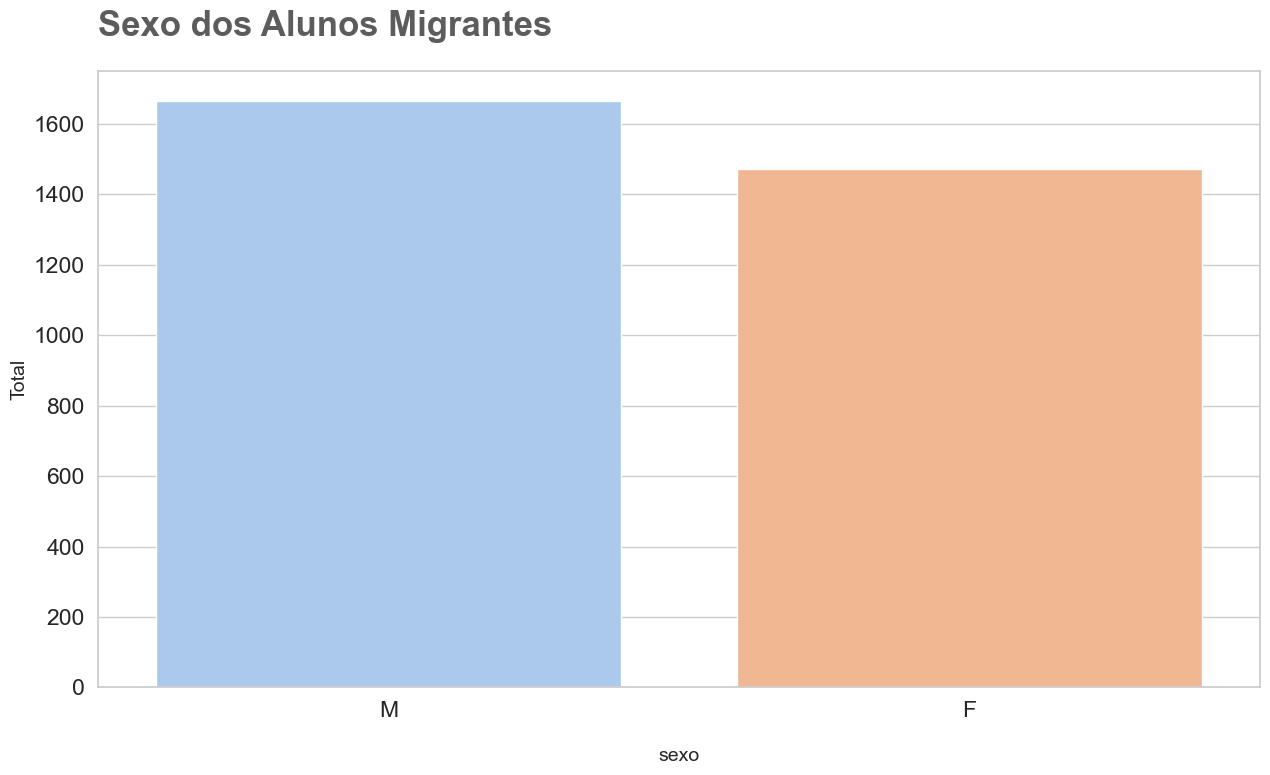

In [38]:
# Gráfico 5 - Análise em Valores Absolutos

# Tamanho da figura
plt.figure(figsize = (15,8))

# Selecionando a paleta de cores
palette = sns.color_palette("pastel")

# Chart
chart = sns.countplot(data = df1.loc[(df1['aluno_migrante'] == 1)], x = 'sexo', palette = palette)

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nsexo", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Adicionado Título
chart.text(x = -0.5,
           y = 1850,
           s = "Sexo dos Alunos Migrantes",
           fontsize = 25,
           weight = 'bold',
           alpha = .75);

Observando a frequência do sexo dos alunos migrantes podemos identificar uma pequena diferença entre os sexo **M** e **F**, no qual o sexo **M** tem um número maior de representantes que o **F**.

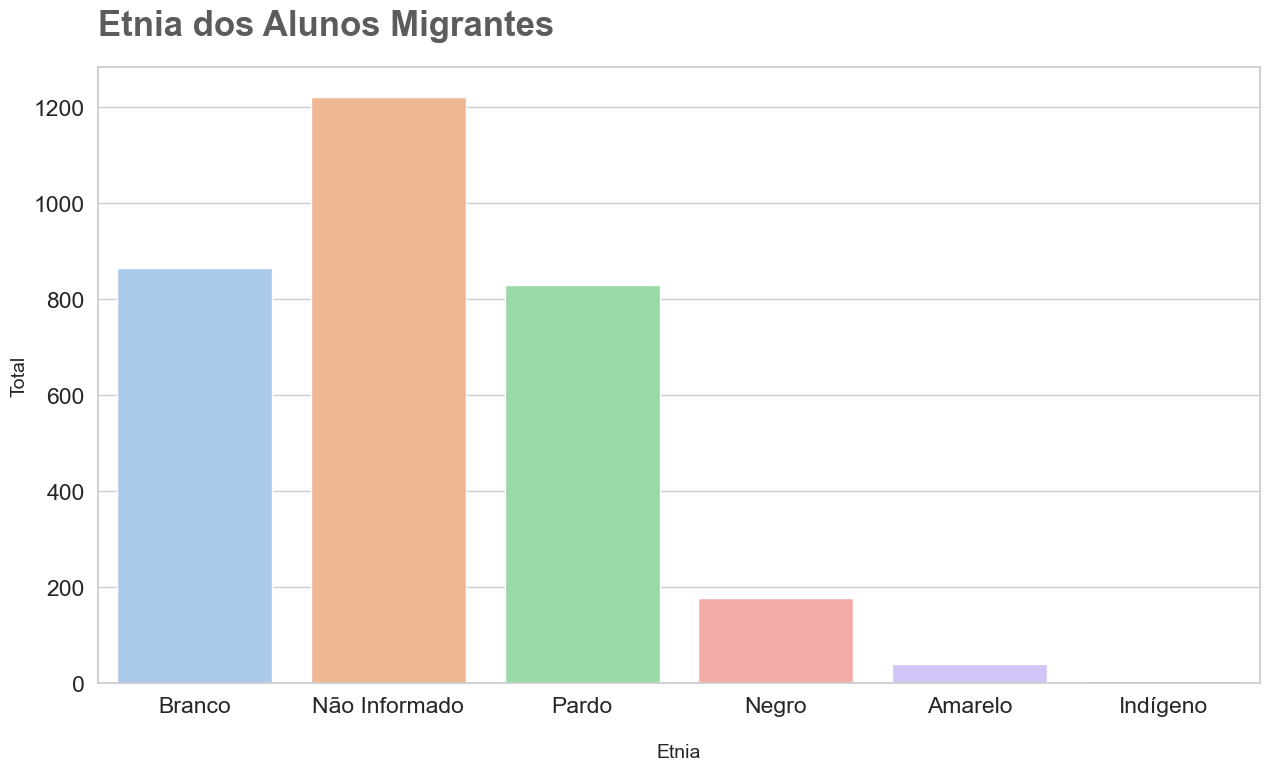

In [39]:
# Gráfico 6 - Análise em Valores Absolutos

# Tamanho da figura
plt.figure(figsize = (15,8))

# Selecionando a paleta de cores
palette = sns.color_palette("pastel")

# Chart
chart = sns.countplot(data = df1.loc[(df1['aluno_migrante'] == 1)], x = 'etnia',  palette=palette)

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nEtnia", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Adicionado Título
chart.text(x = -0.5,
           y = 1350,
           s = "Etnia dos Alunos Migrantes",
           fontsize = 25,
           weight = 'bold',
           alpha = .75);

* Assim como foi visto no grupo dos alunos não migrante, os **Brancos** e **Pardos** também são os mais representativos para o grupo do estudantes migrantes.
 * É importante ressaltar que o maior número de contagem observada para esse grupo **não tem sua etnia informada**.
 * Para os **Indígenas** e **Amarelos** são os que apresentaram menor frequência.

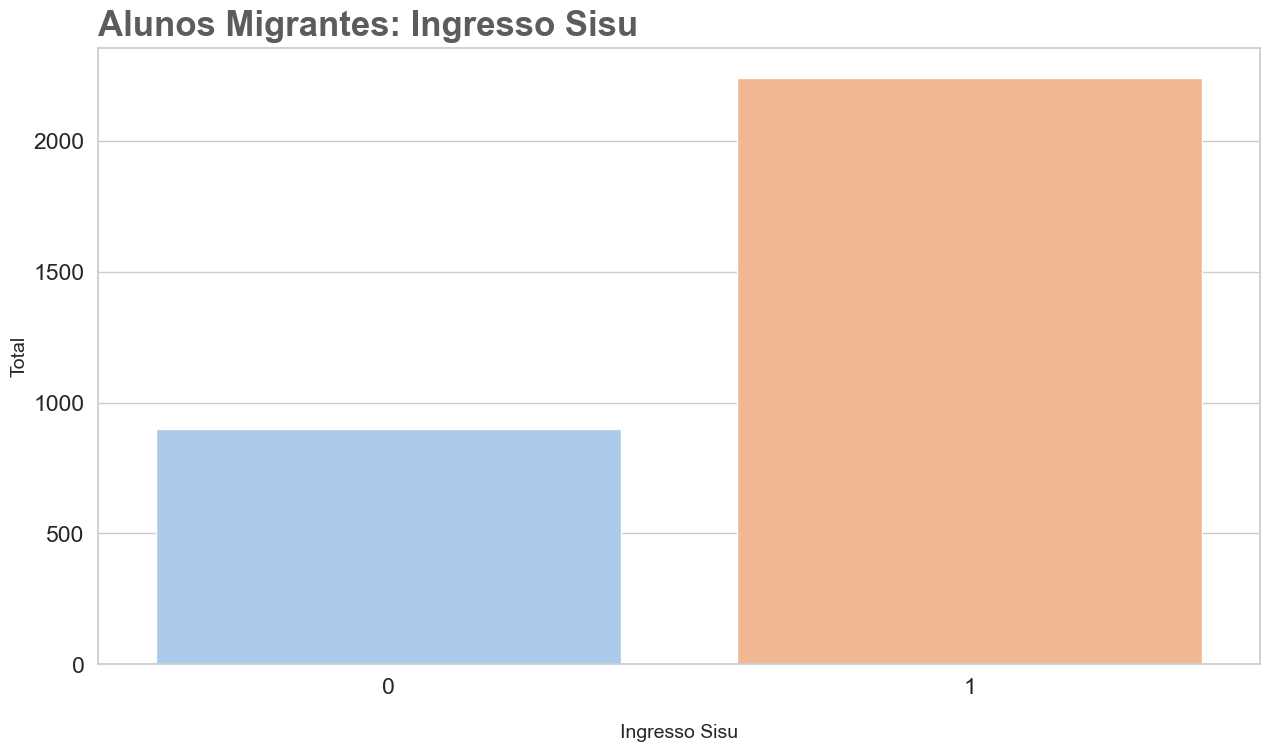

In [40]:
# Gráfico 7 - Análise em Valores Absolutos

# Tamanho da figura
plt.figure(figsize = (15,8))

# Selecionando a paleta de cores
palette = sns.color_palette("pastel")

# Chart
chart = sns.countplot(data = df1.loc[(df1['aluno_migrante'] == 1)], x = 'ingresso_sisu', palette = palette)

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nIngresso Sisu", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Adicionado Título
chart.text(x = -0.5,
           y = 2400,
           s = "Alunos Migrantes: Ingresso Sisu",
           fontsize = 25,
           weight = 'bold',
           alpha = .75);

No gráfico acima podemos ver que a principal forma de ingresso para o grupo do alunos migrante é o Sisu.

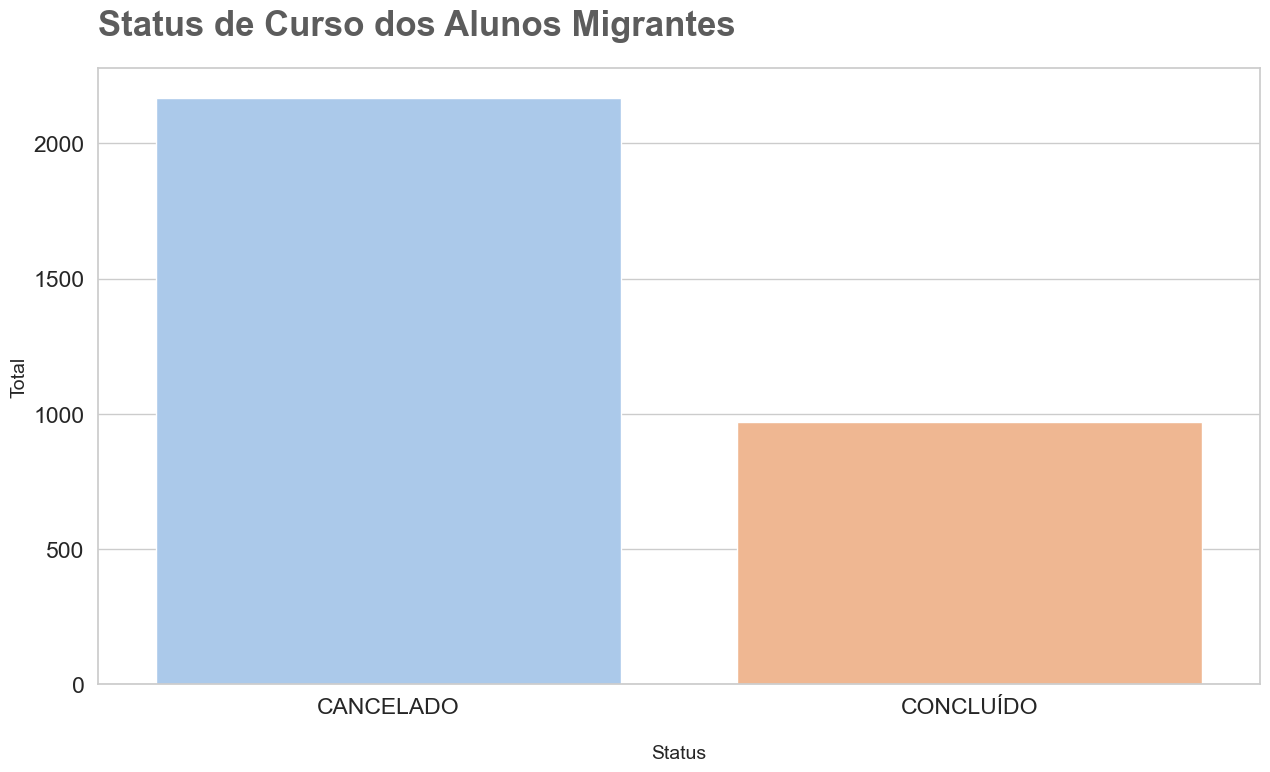

In [41]:
# Gráfico 8 - Análise em Valores Absolutos

# Tamanho da figura
plt.figure(figsize = (15,8))

# Selecionando a paleta de cores
palette = sns.color_palette("pastel")

# Chart
chart = sns.countplot(data = df1.loc[(df1['aluno_migrante'] == 1)], x = 'status', palette = palette)

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nStatus", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Adicionado Título
chart.text(x = -0.5,
           y = 2400,
           s = "Status de Curso dos Alunos Migrantes ",
           fontsize = 25,
           weight = 'bold',
           alpha = .75);

Os estudantes considerados como migrantes apresentam maior frequência para o status de curso **cancelado** em comparação com **concluído**.

#### Algumas considerações sobre os grupos dos *Migrantes* e *Não Migrantes*:

   1. **SEXO** - Os ***migrantes*** apresentaram maior frequência para os estudantes do sexo *MASCULINO*, já o grupo dos alunos ***não migrantes*** apresentou maior contagem para o sexo *FEMININO*. Porém em ambos os casos não foi identificado diferença de grande magnitude.
   
   
   2. **ETNIA** - Os estudantes ***migrantes*** e **Não migrantes** são representados em sua maioria pode alunos considerados *BRANCOS* e *PARDOS*. Esses dois grupos de estudantes também apresentaram um padrão semelhante com os *INDÍGENAS* e *AMARELOS* esses com menor frequência em ambos os grupos. Ainda existe um categoria de estudantes que não tem sua etnia informada e para esses os ***migrantes*** apresentou maior contagem superando os *BRANCOS* e *PARDOS*.
   
   
   3. **INGRESSO SISU** - Foi observado que a maior parte do estudantes ***migrantes*** ingressaram na UFPB por meio do Sistema de Seleção Unificada (sisu), já o grupo dos alunos **Não migrantes** ingressaram na UFPB por meio de sistemas de seleção diferentes do Sisu como vestibular e outros meios de acesso à universidade. 
   
   
   4. **STATUS** - Para essa variável ambos os grupos apresentaram um padrão semelhante, foi visto que estudantes***migrantes*** e **Não migrantes** indicaram maior frequência para o status de curso *CANCELADO* em comparação com o status de curso *CONCLUÍDO*.
   
   
É importante ressaltar que não é adequado fazer comparações com relação aos grupos dos estudantes ***Migrantes*** e **Não migrantes** em termos absolutos para isso seria necessário fazer uma comparação em termos de proporção, pois existe uma grande diferença de observações para esses grupos. Isto posto, a análise acima é direcionada de forma individual para ambos os grupos objetivando identificar padrões nessas variáveis.

### 2.4.8 Análise Bivariada - Mapa de Associação

In [42]:
from scipy.stats import chi2_contingency

# Cria uma tabela de contingência para as variáveis categóricas
table = pd.crosstab(df1['aluno_migrante'], df1['cra'])

# Executa o teste qui-quadrado e armazena o resultado na variável chi2
chi2, p_value, dof, expected = chi2_contingency(table)

# Calcula o coeficiente de contingência
n = table.sum().sum()
cont_coef = np.sqrt(chi2 / (n * (min(table.shape)-1)))
 
# Imprime o resultado
print('Coeficiente de contingência:', cont_coef)

Coeficiente de contingência: 0.1668226848010214


In [43]:
df1.columns

Index(['campus', 'codigo_inep', 'curso_nome', 'turno', 'ano_ingresso',
       'periodo_ingresso', 'forma_ingresso', 'status', 'id_discente',
       'ano_referencia', 'periodo_referencia', 'forma_evasão', 'cra', 'cota',
       'etnia', 'sexo', 'data_nascimento', 'uf_naturalidade', 'mun_residencia',
       'uf_residencia', 'estado_civil', 'ingresso_sisu', 'aluno_migrante'],
      dtype='object')

- Criando variável **Range**

In [44]:
df1['Range'] = range(1, len(df1)+1)

- Criando **df_group1**: groupby das variáveis *aluno_migrante* e *status* e agregando pela variáveis *Range*.

In [45]:
df_group1 = df1.groupby(['aluno_migrante', 'status']).agg({'Range' :'nunique'}).reset_index()
df_group1

,aluno_migrante,status,Range
0,0,CANCELADO,25373
1,0,CONCLUÍDO,17649
2,1,CANCELADO,2169
3,1,CONCLUÍDO,969


- Criando **df_group2**: groupby de *aluno_migrante* e agregando por *Range*. 

In [46]:
df_group2 = df1.groupby('aluno_migrante').agg({'Range' : 'nunique'}).reset_index()
df_group2

,aluno_migrante,Range
0,0,43022
1,1,3138


- Criando **df_group3**: concatenação tabela **df_group1** com **df_group2** por *aluno_migrante*

In [47]:
df_group3 = df_group1.merge(df_group2, on = 'aluno_migrante')
df_group3

,aluno_migrante,status,Range_x,Range_y
0,0,CANCELADO,25373,43022
1,0,CONCLUÍDO,17649,43022
2,1,CANCELADO,2169,3138
3,1,CONCLUÍDO,969,3138


- Criando coluna **Percentual(%)**

In [48]:
df_group3['Percentual(%)'] = df_group3['Range_x'] / df_group3['Range_y'] * 100
df_group3

,aluno_migrante,status,Range_x,Range_y,Percentual(%)
0,0,CANCELADO,25373,43022,58.976803
1,0,CONCLUÍDO,17649,43022,41.023197
2,1,CANCELADO,2169,3138,69.120459
3,1,CONCLUÍDO,969,3138,30.879541


- Renomenado variáveis

In [49]:
df_group3.columns = ['Aluno Migrante',
'status',
'Total Por Categoria',
'Total Migrantes',
'Percentual M(%)']
df_group3

,Aluno Migrante,status,Total Por Categoria,Total Migrantes,Percentual M(%)
0,0,CANCELADO,25373,43022,58.976803
1,0,CONCLUÍDO,17649,43022,41.023197
2,1,CANCELADO,2169,3138,69.120459
3,1,CONCLUÍDO,969,3138,30.879541


- Calculando total de observações por **status**

In [50]:
df_group4 = df1.groupby('status').agg({'Range' : 'nunique'}).reset_index()
df_group4

,status,Range
0,CANCELADO,27542
1,CONCLUÍDO,18618


- Concatenando total de status por categoria 

In [51]:
df_group5 = df_group3.merge(df_group4, on = 'status')
df_group5

,Aluno Migrante,status,Total Por Categoria,Total Migrantes,Percentual M(%),Range
0,0,CANCELADO,25373,43022,58.976803,27542
1,1,CANCELADO,2169,3138,69.120459,27542
2,0,CONCLUÍDO,17649,43022,41.023197,18618
3,1,CONCLUÍDO,969,3138,30.879541,18618


- Calculando percentual por total de status por categória

In [52]:
df_group5['Percentual(%)'] = df_group5['Total Por Categoria'] / df_group5['Range'] * 100
df_group5

,Aluno Migrante,status,Total Por Categoria,Total Migrantes,Percentual M(%),Range,Percentual(%)
0,0,CANCELADO,25373,43022,58.976803,27542,92.124755
1,1,CANCELADO,2169,3138,69.120459,27542,7.875245
2,0,CONCLUÍDO,17649,43022,41.023197,18618,94.795359
3,1,CONCLUÍDO,969,3138,30.879541,18618,5.204641


- Renomenado as colunas 

In [53]:
df_group5.columns = ['Aluno Migrante',
'Status do Curso',
'Total Por Categoria',
'Total por Migrantes',
'Percentual M (%)',
'Total por Status',
'Percentual S (%)']
df_group5

,Aluno Migrante,Status do Curso,Total Por Categoria,Total por Migrantes,Percentual M (%),Total por Status,Percentual S (%)
0,0,CANCELADO,25373,43022,58.976803,27542,92.124755
1,1,CANCELADO,2169,3138,69.120459,27542,7.875245
2,0,CONCLUÍDO,17649,43022,41.023197,18618,94.795359
3,1,CONCLUÍDO,969,3138,30.879541,18618,5.204641


 - Para melhor interpretação vamos visualizar e interpretar essas informações num gráfico.

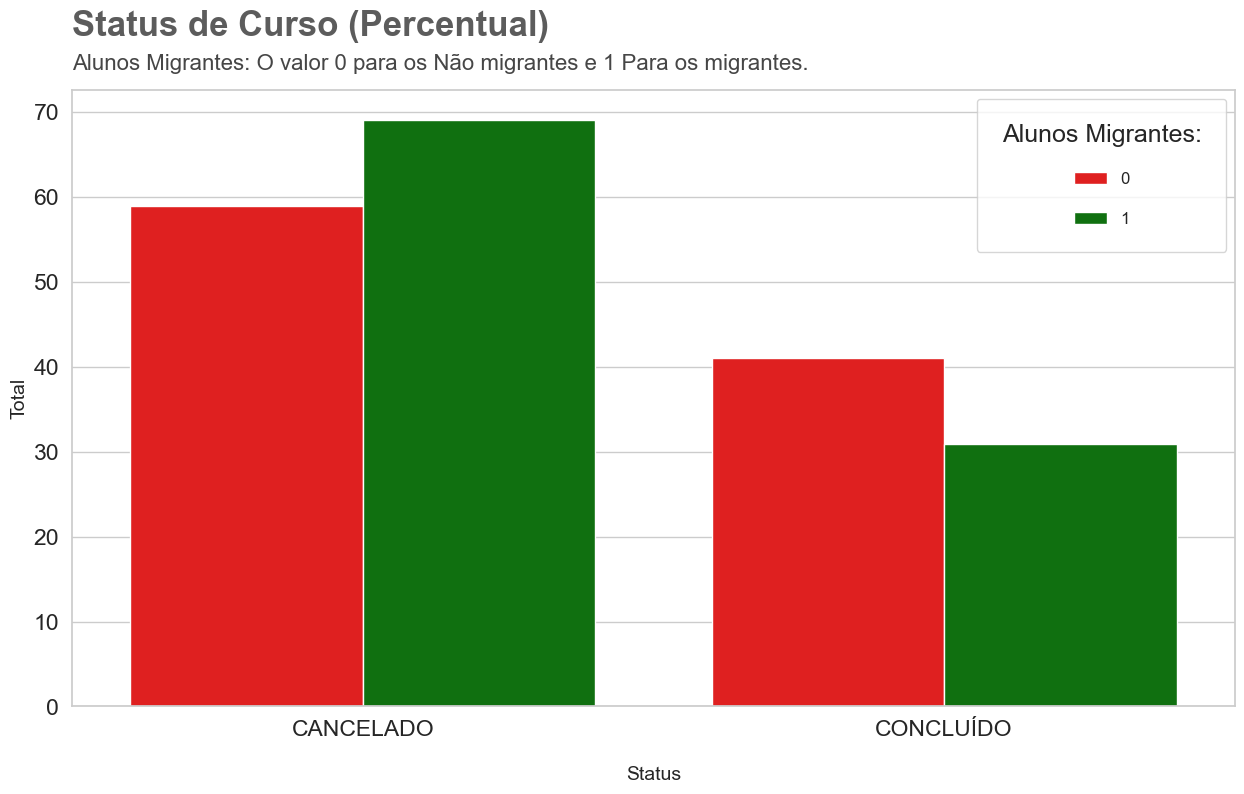

In [54]:
# Gráfico 1 - Análise em Valores Percentual

# Tamanho da figura
plt.figure(figsize = (15,8))

# Chart
chart = sns.barplot(x = 'Status do Curso',
                    y = 'Percentual M (%)',
                    data = df_group5,
                    hue = 'Aluno Migrante',
                    palette = ["red","green"])

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nStatus", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Legenda
plt.legend(loc = 'upper right',
           borderpad = 1.5,
           labelspacing = 1.5,
           fontsize = 12,
           title = 'Alunos Migrantes:')

# Adicionado Título
chart.text(x = -0.5,
           y = 79,
           s = "Status de Curso (Percentual)",
           fontsize = 25,
           weight = 'bold',
           alpha = .75)

# Adicionado Sub-Título
chart.text(x = -0.5,
           y = 75,
           s = 'Alunos Migrantes: O valor 0 para os Não migrantes e 1 Para os migrantes.',
           fontsize = 16,
           alpha = .85);

**Observações**:

1. Para o status de curso cancelado podemos ver que em termos proporcionais os alunos migrantes apresentam uma maior de taxa de cancelamento em comparação com os alunos Não Migrantes, sendo 62,12% e 58,97% respectivamente.
 

2. Já para o status de curso concluído vemos que também existe diferença entre agora o grupo dos alunos não migrantes apresentam maior taxa de conclusão em comparação com o grupo dos alunos migrantes. Aproximadamente 41% para os alunos que possuem residência no estado da Paraíba e aproximadamente 31% para os migrantes.

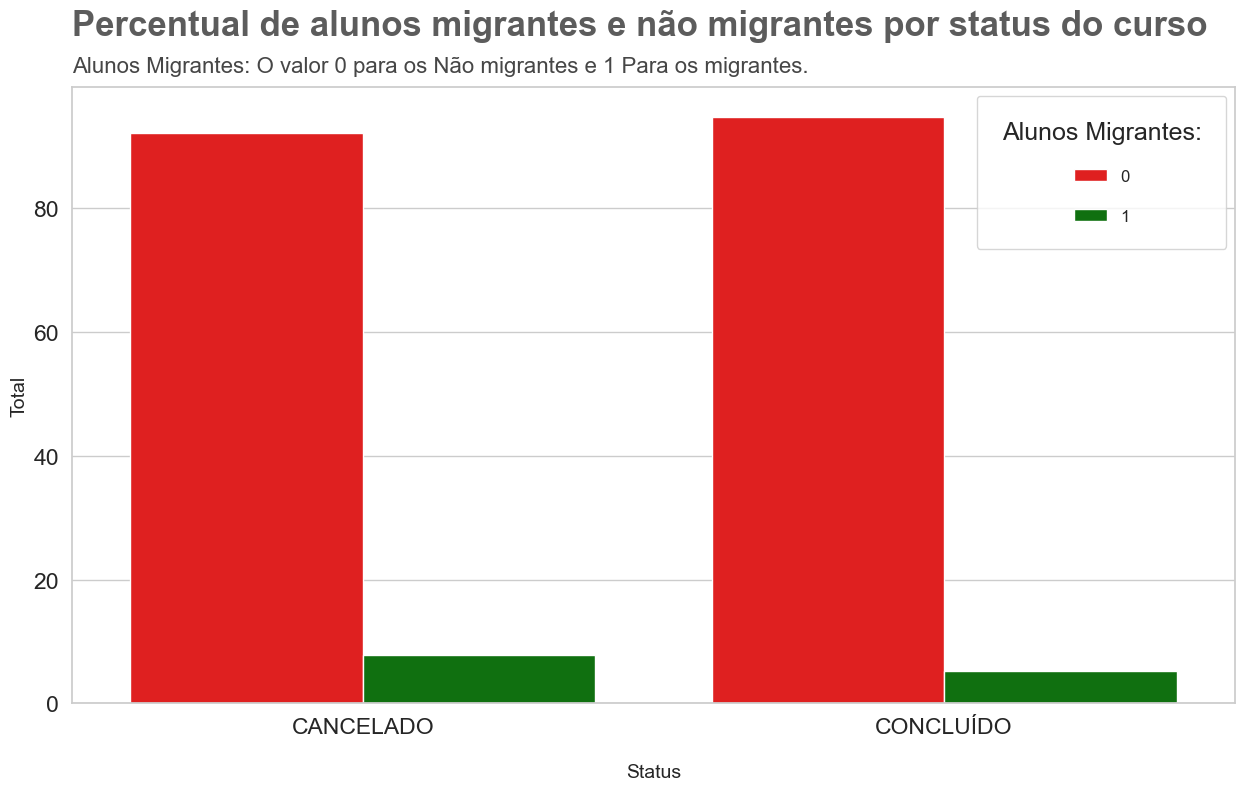

In [55]:
# Gráfico 2 - Análise em Valores Percentual

# Tamanho da figura
plt.figure(figsize = (15,8))

# Chart
chart = sns.barplot(x = 'Status do Curso',
                    y = 'Percentual S (%)',
                    data = df_group5,
                    hue = 'Aluno Migrante',
                    palette = ["red","green"])

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nStatus", fontsize = 14)
chart.set_ylabel("Total", fontsize = 14)

# Legenda
plt.legend(loc = 'upper right',
           borderpad = 1.5,
           labelspacing = 1.5,
           fontsize = 12,
           title = 'Alunos Migrantes:')

# Adicionado Título
chart.text(x = -0.5,
           y = 108,
           s = "Percentual de alunos migrantes e não migrantes por status do curso",
           fontsize = 25,
           weight = 'bold',
           alpha = .75)

# Adicionado Sub-Título
chart.text(x = -0.5,
           y = 102,
           s = 'Alunos Migrantes: O valor 0 para os Não migrantes e 1 Para os migrantes.',
           fontsize = 16,
           alpha = .85);

**Observações**:

1. Observando a proporção de status dos alunos migrantes e não migrantes, foi visto que os estudantes não migrantes tem maior proporção nos status de concluído e cancelado. Os não migrantes representam cerca de 92% dos estudantes com status de curso cancelado e aproximadamente 94% dos alunos com status de concluído.

2. Fazendo uma análise para o grupo estudantes considerados migrantes a proporção em ambos os status é inferior ao grupo do não migrantes. Cerca de 7,87% dos alunos com status de curso cancelado são migrantes e 5,20% do estudantes com status de curso concluído são migrantes.

É importante deixar claro que essa diferença pode ter como causa a diferença de observações disponíveis em cada grupo. Mais à frente talvez seja necessário a aplicação de alguma técnica de rebalanceamento  dessas categorias para que o modelo proposto não sofra viés de aprendizagem, e aprenda mais de uma categoria que outra.

- De forma semelhante a analise feita anteriomente irei fazer com a variável **ingresso_sisu**

In [56]:
df_group6 = df1.groupby(['aluno_migrante', 'ingresso_sisu']).agg({'Range' :'nunique'}).reset_index()
df_group6

,aluno_migrante,ingresso_sisu,Range
0,0,0,27932
1,0,1,15090
2,1,0,898
3,1,1,2240


In [57]:
df_group7 = df1.groupby('aluno_migrante').agg({'Range' : 'nunique'}).reset_index()
df_group7

,aluno_migrante,Range
0,0,43022
1,1,3138


In [58]:
df_group7 = df_group6.merge(df_group7, on = 'aluno_migrante')
df_group7

,aluno_migrante,ingresso_sisu,Range_x,Range_y
0,0,0,27932,43022
1,0,1,15090,43022
2,1,0,898,3138
3,1,1,2240,3138


In [59]:
df_group7['Percentual M (%)'] = df_group7['Range_x'] / df_group7['Range_y'] * 100
df_group7

,aluno_migrante,ingresso_sisu,Range_x,Range_y,Percentual M (%)
0,0,0,27932,43022,64.924922
1,0,1,15090,43022,35.075078
2,1,0,898,3138,28.616953
3,1,1,2240,3138,71.383047


In [60]:
df_group8 = df1.groupby('ingresso_sisu').agg({'Range' : 'nunique'}).reset_index()
df_group8

,ingresso_sisu,Range
0,0,28830
1,1,17330


In [61]:
df_group9 = df_group7.merge(df_group8, on = 'ingresso_sisu')
df_group9

,aluno_migrante,ingresso_sisu,Range_x,Range_y,Percentual M (%),Range
0,0,0,27932,43022,64.924922,28830
1,1,0,898,3138,28.616953,28830
2,0,1,15090,43022,35.075078,17330
3,1,1,2240,3138,71.383047,17330


In [62]:
df_group9['Percentual Sisu (%)'] = df_group9['Range_x'] / df_group9['Range'] * 100
df_group9

,aluno_migrante,ingresso_sisu,Range_x,Range_y,Percentual M (%),Range,Percentual Sisu (%)
0,0,0,27932,43022,64.924922,28830,96.885189
1,1,0,898,3138,28.616953,28830,3.114811
2,0,1,15090,43022,35.075078,17330,87.074437
3,1,1,2240,3138,71.383047,17330,12.925563


In [63]:
df_group9.columns = ['Aluno Migrante',
'Forma de Ingresso (sisu)',
'Total Por Categória',
'Total por Migrantes',
'Percentual M (%)',
'Total por Forma de Ingresso',
'Percentual (sisu) (%)']
df_group9

,Aluno Migrante,Forma de Ingresso (sisu),Total Por Categória,Total por Migrantes,Percentual M (%),Total por Forma de Ingresso,Percentual (sisu) (%)
0,0,0,27932,43022,64.924922,28830,96.885189
1,1,0,898,3138,28.616953,28830,3.114811
2,0,1,15090,43022,35.075078,17330,87.074437
3,1,1,2240,3138,71.383047,17330,12.925563


* Vamos analisar as informações da tabela **df_group9** em gráficos.

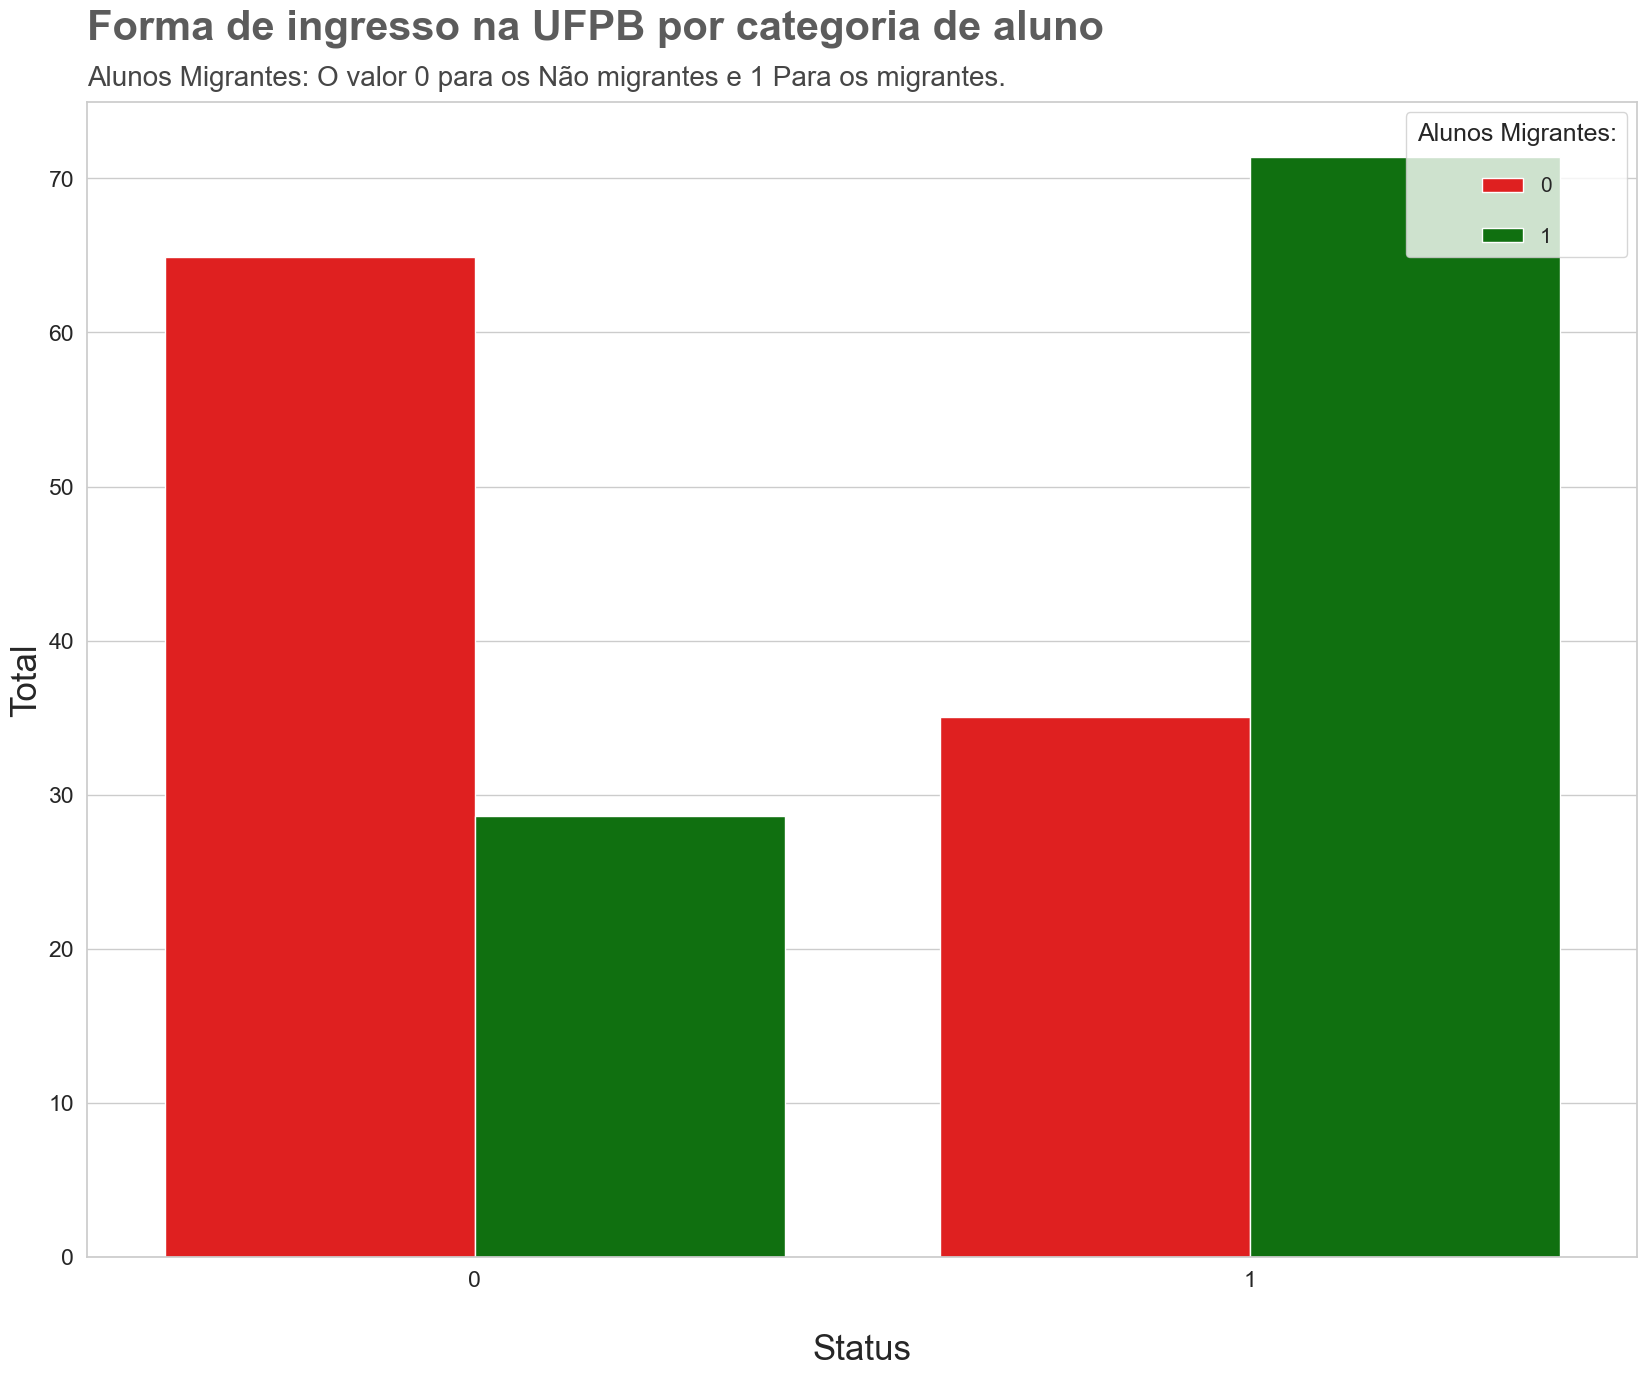

In [64]:
# Gráfico 3 - Análise em Valores Percentual

# Tamanho da figura
plt.figure(figsize = (20,15))

# Chart
chart = sns.barplot(x = 'Forma de Ingresso (sisu)',
                    y = 'Percentual M (%)',
                    data = df_group9,
                    hue = 'Aluno Migrante',
                    palette = ["red","green"])

# Estilo e labels
sns.set(font_scale = 1.5)
sns.set_style('whitegrid')
sns.set_palette('prism')
chart.set_xlabel("\nStatus", fontsize = 25)
chart.set_ylabel("Total", fontsize = 25)

# Legenda
plt.legend(loc = 'upper right',
           borderpad = 0.5,
           labelspacing = 1.5,
           fontsize = 15,
           title = 'Alunos Migrantes:')

# Adicionado Título
chart.text(x = -0.5,
           y = 79,
           s = "Forma de ingresso na UFPB por categoria de aluno",
           fontsize = 30,
           weight = 'bold',
           alpha = .75)

# Adicionado Sub-Título
chart.text(x = -0.5,
           y = 76,
           s = 'Alunos Migrantes: O valor 0 para os Não migrantes e 1 Para os migrantes.',
           fontsize = 20,
           alpha = .85);

Observações:
- Foi atribuído o valor *1* para os estudantes que ingressaram na UFPB por meio de Sisu e *0* por outros meios de ingresso.


1. Ao observar o gráfico é visto que existe uma diferença entre os grupos de estudantes migrantes e não migrante com a forma de ingresso a UFPB.


2. Os estudantes não migrantes da Universidade Federal da Paraíba em sua maior parte utilizaram meios de ingresso diferente do Sisu para ingressar na instituição. Aproximadamente 65% utilizaram outros meios de acesso e cerca de 35% ingressaram por meio de Sisu.


3. Já o grupo dos estudantes migrantes apresentaram como principal meio de acesso o Sisu, sendo 71.38%. E 28.61% utilizaram outros meios de acesso.

**Conclusão** - Feita essa comparação de forma proporcional, foi possível detectar uma diferença no principal meio de acesso para o grupo dos estudantes migrantes e não migrantes. O primeiro grupo tem o Sisu como seu principal meio de acesso e os não migrantes utilizam outros meios de ingresso a UFPB.

### Dividindo Dados em Treino e Teste

In [70]:
# Criando obejeto com a variável target
y = df1['aluno_migrante']

In [71]:
x = df1.drop('aluno_migrante', axis = 1)

## Pré-Processamento

In [78]:
x_treino, x_teste, y_treino, y_teste = train_test_split(x,
                                                        y,
                                                        test_size =0.30,
                                                        random_state = 123,
                                                        stratify = df1.aluno_migrante)

In [79]:
# Print do shape
print(x_treino.shape, x_teste.shape, y_treino.shape, y_teste.shape)

(32312, 23) (13848, 23) (32312,) (13848,)


### Label Encoding

In [74]:
df1.columns

Index(['campus', 'codigo_inep', 'curso_nome', 'turno', 'ano_ingresso',
       'periodo_ingresso', 'forma_ingresso', 'status', 'id_discente',
       'ano_referencia', 'periodo_referencia', 'forma_evasão', 'cra', 'cota',
       'etnia', 'sexo', 'data_nascimento', 'uf_naturalidade', 'mun_residencia',
       'uf_residencia', 'estado_civil', 'ingresso_sisu', 'aluno_migrante',
       'Range'],
      dtype='object')

In [80]:
var2 = ['campus','codigo_inep','curso_nome','turno','periodo_ingresso','forma_ingresso','status','id_discente',
       'periodo_referencia','forma_evasão','cota','etnia','sexo','uf_naturalidade','mun_residencia','uf_residencia',
       'estado_civil']

In [81]:
# Aplicando o LabelEncoder em cada coluna
encoders = {}
for coluna in var2:
    encoder = LabelEncoder()
    x_treino[coluna] = encoder.fit_transform(x_treino[coluna])
    encoders[coluna] = encoder

In [83]:
x_treino

,campus,codigo_inep,curso_nome,turno,ano_ingresso,periodo_ingresso,forma_ingresso,status,id_discente,ano_referencia,...,cota,etnia,sexo,data_nascimento,uf_naturalidade,mun_residencia,uf_residencia,estado_civil,ingresso_sisu,Range
54803,2,3,16,1,2014,0,6,0,22798,2014,...,0,4,1,1995-05-12 00:00:00,16,215,15,7,1,35765
20489,2,91,24,1,2010,0,27,1,2090,2015,...,0,1,1,1993-01-30 00:00:00,18,215,15,7,0,1461
58249,2,0,18,1,2014,1,6,0,27335,2015,...,0,4,0,1995-06-27 00:00:00,16,215,15,7,1,39211
35848,0,9,90,1,2012,0,21,1,11113,2015,...,0,5,1,1993-02-26 00:00:00,16,320,15,7,0,16814
34272,2,22,67,1,2011,1,27,1,6716,2016,...,0,5,0,1991-12-02 00:00:00,16,57,15,7,0,15239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44277,2,3,16,2,2013,1,27,0,18668,2016,...,0,5,0,1982-07-05 00:00:00,16,336,15,2,0,25242
30644,2,5,14,1,2011,0,7,1,9130,2010,...,0,4,0,1988-04-10 00:00:00,16,215,15,7,0,11612
47843,2,64,39,1,2013,0,27,0,21227,2015,...,15,5,1,1992-03-05 00:00:00,16,215,15,7,0,28807
28720,2,4,24,1,2011,0,6,1,8950,2016,...,3,5,1,1991-08-19 00:00:00,16,215,15,7,1,9688


### Balanceamento de Classe

# continua